In [29]:
from collections import OrderedDict

import os
import numpy as np
import torch


torch.set_printoptions(sci_mode=False)

from src.polar_traversal import (
    Bridge,
    make_latitudes,
    get_start,
    gather_path,
    cumulative_distances,
)

def get_sample(pos, normed, path_points, path_normals):    
    i = 1
    while i < len(normed):
        d0, d1 = normed[i-1], normed[i]
        if pos <= d1:
            ratio = (pos - d0) / (d1 - d0) 
            pnt = ratio * path_points[i-1] + (1 - ratio) * path_points[i]
            nrm = ratio * path_normals[i-1] + (1 - ratio) * path_normals[i]
            return pnt, nrm, i
        i += 1
    raise (pos, normed, path)

def single_path_sample(path, layer_no, total_layers):
    cumulative = cumulative_distances(path['points'])
    normed =  cumulative / cumulative[-1]
    pos = (layer_no+1) / (total_layers+1)
    pnt, nrm, _ = get_sample(pos, normed, 
                             path['points'], path['normals'])
    return pnt, nrm

def get_angles_series(n):
    return [x for x in range(0, n*2+1, 2)]

def get_shifted_latitudes(no):
    lats = make_latitudes(no)
    rot = len(lats) // 4
    return np.vstack([lats[rot:], lats[:rot]])

def get_sample(pos, normed, path_points, path_normals):    
    i = 1
    while i < len(normed):
        d0, d1 = normed[i-1], normed[i]
        if pos <= d1:
            ratio = (pos - d0) / (d1 - d0) 
            pnt = ratio * path_points[i-1] + (1 - ratio) * path_points[i]
            nrm = ratio * path_normals[i-1] + (1 - ratio) * path_normals[i]
            return pnt, nrm, i
        i += 1
    raise (pos, normed, path)

def single_path_sample(path, layer_no, total_layers):
    cumulative = cumulative_distances(path['points'])
    normed =  cumulative / cumulative[-1]
    pos = layer_no / total_layers    
    pnt, nrm, _ = get_sample(pos, normed, 
                             path['points'], path['normals'])
    return torch.tensor(pnt).float(), torch.tensor(nrm).float()

def square_indices(n):
    max_idx = 2 * (n+1)
    res = [[0, x] for x in range(max_idx -1, -1, -1)]\
        + [[x, 0] for x in range(1, max_idx)]\
        + [[max_idx -1, x] for x in range(1, max_idx)]\
        + [[x, max_idx -1] for x in range(max_idx -2, 0, -1)]
    return res

def shifted_square_indices(sq_no, square_no):    
    sq_ids =  square_indices(sq_no)
    ost = square_no - sq_no
    return [(i+ost, k+ost) for (i, k) in iter(sq_ids)]

class Blueprint:
    
    def __init__(self, path):
        self.path = path
        self.bridge = Bridge(path)
        
    def __repr__(self):
        return f'Blueprint: {self.path}'    

    def grid_sample(self, square_no, save_path):
        side = (square_no + 1) * 2
        res = self.load_result(save_path) if save_path and os.path.exists(save_path) \
            else self.create_result(side)
            
#         points = torch.zeros(1, 3, side, side)
#         normals = torch.zeros(1, 3, side, side)
#         grid =  torch.zeros(side, side) - 9
        
        face_id, point, normal = get_start(self.bridge.mesh)
        for sq_no in range(square_no+1):
            print(sq_no, res['sq_no'][0])
            if sq_no > res['sq_no'][0]:                                
                side = (sq_no + 1) * 2
                sq_ids = shifted_square_indices(sq_no, square_no)            
                angles_no = len(sq_ids)
                latitudes = get_shifted_latitudes(angles_no)            
                for (r, c), latitude in zip(sq_ids, latitudes):
                    path = gather_path(latitude, face_id, point, normal, self.bridge)                
                    pnt, nrm = single_path_sample(path, sq_no, square_no)
                    res['points'][0, :, c, r] = pnt
                    res['normals'][0, :, c, r] = nrm                
                    res['grid'][c, r] = float(sq_no)                
                res['sq_no'][0] = sq_no
                self.save_result(res, save_path)
        return res            
        
    def create_result(self, side):
        return {
            'points': torch.zeros(1, 3, side, side),
            'normals': torch.zeros(1, 3, side, side),
            'grid': torch.zeros(side, side) - 9,
            'sq_no': torch.tensor([-1]),
        }
    
    def load_result(self, path):
        loaded = np.load(path)
        
        return {
            'points': torch.tensor(loaded['points']).float(),
            'normals': torch.tensor(loaded['normals']).float(),
            'grid': torch.tensor(loaded['grid']).float(),
            'sq_no': torch.tensor(loaded['sq_no']).long(),
        }
    
    def save_result(self, res, path):
        #assert type('s')  == 'str'
        print('path', path, res['sq_no'])
        np.savez_compressed(
            path,
            points=res['points'].numpy(),
            normals=res['normals'].numpy(),
            grid=res['grid'].numpy(),
            sq_no=res['sq_no'].numpy(),
        )
        

stl_path = './data/centered_3.stl'

square_no = 127
blueprint = Blueprint(stl_path)
print(blueprint)

blueprint_path = './data/blueprint{}.npz'.format(square_no)
print(blueprint_path)
res = blueprint.grid_sample(square_no, blueprint_path)
res['points'].shape, res['normals'].shape

Blueprint: ./data/centered_3.stl
./data/blueprint127.npz
0 tensor(-1)
path ./data/blueprint127.npz tensor([0])
1 tensor(0)
path ./data/blueprint127.npz tensor([1])
2 tensor(1)
path ./data/blueprint127.npz tensor([2])
3 tensor(2)
path ./data/blueprint127.npz tensor([3])
4 tensor(3)
path ./data/blueprint127.npz tensor([4])
5 tensor(4)
path ./data/blueprint127.npz tensor([5])
6 tensor(5)
path ./data/blueprint127.npz tensor([6])
7 tensor(6)
path ./data/blueprint127.npz tensor([7])
8 tensor(7)
path ./data/blueprint127.npz tensor([8])
9 tensor(8)
path ./data/blueprint127.npz tensor([9])
10 tensor(9)
path ./data/blueprint127.npz tensor([10])
11 tensor(10)
path ./data/blueprint127.npz tensor([11])
12 tensor(11)
path ./data/blueprint127.npz tensor([12])
13 tensor(12)
path ./data/blueprint127.npz tensor([13])
14 tensor(13)
path ./data/blueprint127.npz tensor([14])
15 tensor(14)
path ./data/blueprint127.npz tensor([15])
16 tensor(15)
path ./data/blueprint127.npz tensor([16])
17 tensor(16)
path ./

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

In [24]:
res['grid']

tensor([[31., 31., 31.,  ..., 31., 31., 31.],
        [31., 30., 30.,  ..., 30., 30., 31.],
        [31., 30., 29.,  ..., 29., 30., 31.],
        ...,
        [31., 30., 29.,  ..., 29., 30., 31.],
        [31., 30., 30.,  ..., 30., 30., 31.],
        [31., 31., 31.,  ..., 31., 31., 31.]])

In [30]:
import trimesh

from src.util import make_faces
_, _, w, h,  = res['points'].shape
faces = make_faces(w, h)
faces.shape

b_vertices = res['points'].squeeze().reshape(3, -1).t()
print(b_vertices.shape)

mesh = trimesh.Trimesh(vertices=b_vertices, faces=faces)
mesh.show()

mesh.export('./m1.stl');

torch.Size([65536, 3])


In [31]:
mesh.show();

In [37]:
blueprint = torch.load('./data/blueprint.pt')
blueprint['vertices'].shape, blueprint['normals'].shape

(torch.Size([1, 3, 16, 16]), torch.Size([1, 3, 16, 16]))

In [38]:
blueprint = torch.load('./data/blueprint.pt')
blueprint['vertices'].shape, blueprint['normals'].shape

(torch.Size([1, 3, 16, 16]), torch.Size([1, 3, 16, 16]))

In [5]:
from src.renderer import Renderer
from src.config import get_parser

device =  torch.device("cuda")

parser  = get_parser()
opt = parser.parse_args(args=[])
opt

renderer = Renderer(opt).to(device)
renderer

Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

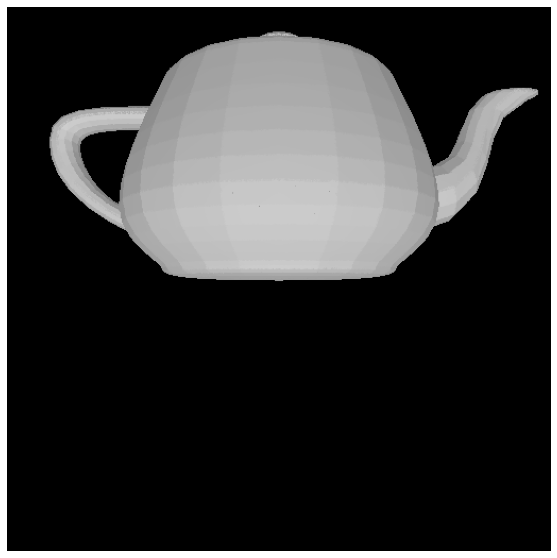

In [6]:
from pytorch3d.ops import sample_points_from_meshes


from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.io import load_obj
from pytorch3d.renderer import (
    FoVOrthographicCameras, 
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ =  load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
textures =  TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch
teapot_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures,
)
teapot_mesh

n_points = 1000000
vertices, normals = sample_points_from_meshes(teapot_mesh, 
    n_points, return_normals=True)

vertices =  vertices[0].to(device)
normals =  normals[0].to(device)

rgb = torch.ones((n_points, 4), device=device) - 0.3

point_cloud = Pointclouds(points=[vertices], 
                          normals=[normals],
                          features=[rgb],)


import matplotlib.pyplot as plt

images =  renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [103]:
from src.util import make_faces

blueprint = torch.load('./data/blueprint.pt')
blueprint['vertices'].shape, blueprint['normals'].shape

(torch.Size([1, 3, 64, 64]), torch.Size([1, 3, 64, 64]))

(7938, 3)

In [105]:
import trimesh

from src.util import make_faces
_, _, w, h,  = res['vertices'].shape
faces = make_faces(w, h)
faces.shape

b_vertices = res['vertices'].squeeze().reshape(3, -1).t()
print(b_vertices.shape)

mesh = trimesh.Trimesh(vertices=b_vertices, faces=faces)
mesh.show()

mesh.export('./m1.stl');

torch.Size([4096, 3])


In [98]:
b_vertices

tensor([[    -0.4748,     -0.0074,      0.0098],
        [    -0.4714,     -0.0456,      0.0073],
        [    -0.4714,     -0.0997,      0.0077],
        [    -0.4621,     -0.1538,      0.0094],
        [    -0.4513,     -0.2054,      0.0101],
        [    -0.4372,     -0.2502,      0.0088],
        [    -0.4160,     -0.3041,      0.0079],
        [    -0.3894,     -0.3537,      0.0080],
        [    -0.3631,     -0.3935,      0.0072],
        [    -0.3298,     -0.4731,      0.0164],
        [    -0.3551,     -0.6163,      0.0106],
        [    -0.2953,     -0.6792,      0.0583],
        [    -0.2219,     -0.6885,      0.0797],
        [    -0.1571,     -0.7049,      0.1311],
        [    -0.0756,     -0.7243,      0.2034],
        [    -0.0000,     -0.7314,      0.2317],
        [    -0.4807,      0.0471,      0.0074],
        [    -0.4587,     -0.0014,      0.1702],
        [    -0.4571,     -0.0542,      0.1533],
        [    -0.4574,     -0.1219,      0.1295],
        [    -0.4527

In [106]:
mesh.show()

In [9]:
from pytorch3d.structures import Meshes

verts = blueprint['vertices'].reshape(-1, 3)
faces_idx = torch.tensor(faces)
mesh = Meshes(verts=[verts], faces=[faces_idx])
mesh

In [10]:
norms = mesh.faces_normals_list()[0]
norms.shape

torch.Size([1922, 3])

In [11]:
norms = mesh.faces_normals_list()[0]
norms.shape

torch.Size([1922, 3])

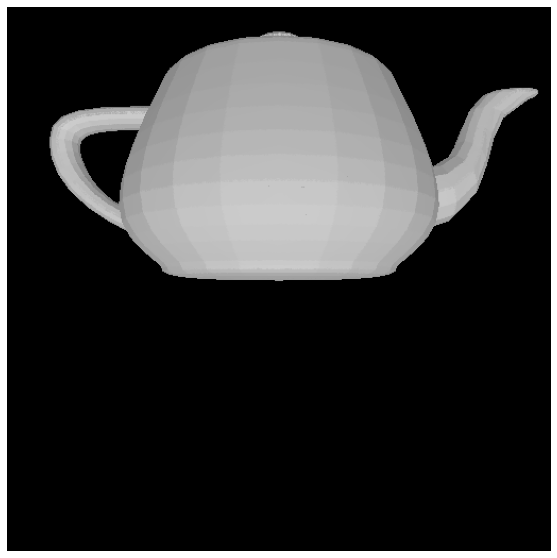

In [13]:
import matplotlib.pyplot as plt

images =  renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [62]:
blueprint['vertices']

tensor([[[[    -0.1399,     -0.0000,      0.1399,      0.2501,      0.3472,
                0.3744,      0.4209,      0.4558,      0.4706,      0.4755,
                0.4797,      0.5003,      0.4980,      0.4931,      0.4599,
                0.3486],
          [    -0.2802,     -0.1379,      0.0066,      0.1442,      0.2846,
                0.3456,      0.4003,      0.4484,      0.4572,      0.4587,
                0.4676,      0.4762,      0.4571,      0.4258,      0.3675,
                0.1762],
          [    -0.3472,     -0.2787,     -0.1627,     -0.0117,      0.1567,
                0.2761,      0.3684,      0.4053,      0.4375,      0.4404,
                0.4281,      0.4314,      0.3648,      0.3240,      0.2000,
                0.0000],
          [    -0.3799,     -0.3420,     -0.2829,     -0.1671,     -0.0108,
                0.1501,      0.2964,      0.3566,      0.3988,      0.3979,
                0.3392,      0.3079,      0.2583,      0.2093,      0.0000,
             